In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance as spy
import time

In [2]:
files=["Data/1in_cubic.txt","Data/1in_linear.txt","Data/1in_sine.txt","Data/1in_tanh.txt","Data/2in_complex.txt","Data/2in_xor.txt"]
outputs=1 #define how many outputs are in the data-set
upperBound=1 #upper limit for weights and biases
lowerBound=-1 #lower limit for weights and biases
minimumDistance=0.01#minimum cosine distance for particles to maintain

In [12]:
#read file and split the input(x) and outputs(y)
def loadFile(File,outputs):
    dd=pd.read_csv(File, delim_whitespace=True, header=None).to_numpy() 
    cols=dd.shape[1]
    rows=dd.shape[0]
    x=dd[:,0:cols-outputs].reshape((rows,(cols-outputs))).reshape(rows,cols-outputs)
    y=dd[:,cols-outputs:].reshape((rows,(outputs))).reshape(rows,outputs) 
    return x,y
x,y=loadFile(files[3],outputs)

In [13]:
#activation function definition (np.tanh and np.cos are used from numpys library)
#These functions are passed by functionSelector() 
def sigmoid(n): return np.divide(1,np.add(np.exp(-n),1))
def NULL(n): return n
def gaussian(n): return np.exp(-np.divide(np.power(n,2),2))

def bounce(xx,minN,maxN):# bounce is a function that returns position after a particle bounces of the boundry(min & max)
    mask1=xx<minN #generate a mask where this condition is true
    mask2=xx>maxN 
    xx[mask1]=minN-(xx[mask1]-np.ceil(xx[mask1]))# return the bounce if the position is outside the boundry
    xx[mask2]=maxN-(xx[mask2]-np.floor(xx[mask2]))# Example: value = 1.3 if the boundry is 1 it returns 0.7 
    return xx

Neural Network Architecture

In [14]:
class NN:
    def __init__(self, network=[1,7,1]):
        self.networkInf=network#Store architecture for future use to avoid recomputing it
        self.layers=len(network)-1 #Total number of layers with weights and biases
        self.weights=[np.random.uniform(lowerBound,upperBound,w) for w in network[1:]] #create an array of weights for each layer 
        self.MatBias=[np.random.uniform(lowerBound,upperBound,w) for w in network[1:]] #create an array of biases for each layer
        self.activationFn=np.random.uniform(lowerBound,upperBound,self.layers)  #assign a random activation function for each layer    
    
    def functionSelector(self,num): #function selector is used in FeedForward() returns an activation function given a layer number 
        num=self.activationFn[num] 
        if(num<-1): raise Exception("Function number too small num<0: {0}".format(num))
        if(num<=-0.4): return NULL
        if(num<=-0.8): return sigmoid
        if(num<=0.2): return np.tanh
        if(num<=0.6): return gaussian
        if(num<=1.0): return np.cos
        if(1<num): raise Exception("Function number too large 1<num: {0}".format(num)) 
            
    def feedForward(self,inputs): #propegates inputs forward through the network and outputs predictions 
        count=len(inputs)
        results=[None]*count
        for row in range(count):
            x2=inputs[row]
            for xx in range(self.layers):
                x2=np.outer(x2,self.weights[xx]) #calculates outer product which is equivelent to transposing and multiplying two vectors
                x2=x2.sum(axis=0) #sums up all the rows of  the multiplication giving us the "z" before the bias is applied
                x2=np.add(x2,self.MatBias[xx]) # adds the bias of each row/neuron
                x2=self.functionSelector(xx)(x2)  #applies the activation function for each layer
            results[row]=x2
        return results
    
    def flatten(self): #returns itself as a vector (feature vector is this order to minimize loops)
        self.vectorLength=sum(self.networkInf[1:])*2+self.layers
        vector=(self.vectorLength)*[None]
        index=0
        for layer in range(self.layers): #move throught layers
            vector[index]=self.activationFn[layer] #add the activation function
            index+=1
            for w in range(len(self.weights[layer])): #weight and bias pairs for each neuron
                vector[index]=self.weights[layer][w]
                index+=1
                vector[index]=self.MatBias[layer][w]
                index+=1
        return vector
    def applyVector(self, vector): #applies a vector to the neural network
        index=0
        for layer in range(self.layers):
            self.activationFn[layer]=vector[index]
            index+=1
            for w in range(len(self.weights[layer])):
                self.weights[layer][w]=vector[index]
                index+=1
                self.MatBias[layer][w]=vector[index]
                index+=1
       

Particle Object Definition

In [15]:
class Particle:
    def __init__(self, network=[1,7,1]): 
        self.wholeNN=NN(network) #each particle is a neural network
        self.vectorNN=self.wholeNN.flatten() #retrive current position
        self.velocityNN=np.random.uniform(lowerBound,upperBound,self.wholeNN.vectorLength)-np.random.uniform(lowerBound,upperBound,self.wholeNN.vectorLength)
        self.pBest=-10000 #Large initial personal best value
        self.fittestLocation=self.vectorNN       
        self.hasVelocity=True #helps avoid checking the whole list once a particle has stopped 
        
    def ifVelocity(self):
        if self.hasVelocity==False: 
            return False
        for layer in self.velocityNN: #If a single value is greater than 0 it has velocity
            if layer !=0: 
                self.hasVelocity=True
                return True
        self.hasVelocity=False
        return False

    def assessFitness(self,data,actual):#returns the mean squared error MSE
        self.fitness=-(np.power(np.subtract(actual,self.wholeNN.feedForward(data)),2).mean())
    
    def findParticleInformants(self,particles,maxDistance,maxGroupSize):#finds nearby particles with cosine distance less than or equal to maxDistance
        informants = []
        for p in particles:
            distance=spy.cosine(self.vectorNN, p.vectorNN)
            if (distance<=maxDistance and distance >=minimumDistance):
                informants.insert(0,p)
                if(len(informants)==maxGroupSize): return informants
        return informants
    
    def updateVelocity(self, fittestlocal, fittestGlobalBest, alpha, beta, gamma, delta):
        dimensions=self.wholeNN.vectorLength 
        vI=np.multiply(self.velocityNN,alpha)
        vpb=np.multiply(np.random.uniform(0, beta,dimensions),np.subtract(self.fittestLocation, self.vectorNN))
        vpc=np.multiply(np.random.uniform(0, gamma,dimensions),np.subtract(fittestlocal, self.vectorNN))
        vpd=np.multiply(np.random.uniform(0, delta,dimensions),np.subtract(fittestGlobalBest, self.vectorNN))
        vIbcd=np.add(vpd,np.add(vpc,np.add(vpb,vI)))        
#         self.velocityNN= bounce(vIbcd,lowerBound,upperBound) 
        self.velocityNN= np.clip(vIbcd,lowerBound,upperBound) 
#         self.velocityNN=vIbcd
        
    def applyV(self): 
        self.wholeNN.applyVector(self.vectorNN)

PSO Algorithm

In [16]:
def PSO(neuralNetworkConfig=[1,5,1],swarmC=10,alpha=0.9,beta=2.5,gamma=1.5,delta=0,jSize=1.0,maxDistance=0.30,maxGroupSize=4,iterations=500):
    t0=time.time()
    swarm=[None]*swarmC 
    for part in range(swarmC):#Create Particles
        swarm[part]=Particle(network=neuralNetworkConfig)
    globalBest=None
    gBest=-10000# large value to avoid checking gBest==none every iteration 
    for ii in range(iterations):#Run N times
        for p in swarm:        
            if (p.hasVelocity):#for every particle that has a velocity    
                p.assessFitness(x,y) 
                if(p.pBest < p.fitness): #if their current fitness is better than their previous
                    p.pBest=p.fitness    #save current score and location as the personal best score and location
                    p.fittestLocation=p.vectorNN
                    if gBest < p.fitness: #if the current fitness is greater than the best global fitness 
                        gBest = p.fitness #save current score and location as the global best score and location
                        globalBest=p.fittestLocation
        for p in swarm:                 
            if (p.hasVelocity):#for every particle that has a velocity                     
                informants=p.findParticleInformants(swarm, maxDistance,maxGroupSize) #find nearby particles
                localBest = p.fitness #includes itself by making itself the fittest location
                fittestLocalBest = p.fittestLocation
                for inf in informants: #finds the fittest informant        
                    if  localBest < inf.pBest : 
                        localBest=inf.pBest
                        fittestLocalBest=inf.fittestLocation
                p.updateVelocity(fittestLocalBest,globalBest,alpha,beta,gamma,delta) #update the velocity to go towards the personal,local, and global bests
        for p in swarm:
            if(p.ifVelocity()):#updates the position to the new position if the particle has velocity and keeps the position within the bounds (np.clip)
                p.vectorNN=np.clip(np.add(p.vectorNN,np.multiply(p.velocityNN,jSize)),lowerBound,upperBound)
                p.applyV() #applys the changes to the neural network

    return gBest,globalBest,(time.time()-t0)

PSO Configuration

In [17]:
swarmSize=50
a=0.9#velocity retention ratio alpha
b=1.5 #Personal velocity retention upper limit
g=2.5 #Local velocity retention upper limit
d=0 #Global velocity retention upper limit
j=1.0 #Particle Jump Size 
maxD=0.30 #Max distance of each particle from the particle informants
maxGS=4 #max number of informants a particle can have
NNConfig=[1,5,1] #The network configeration you want to use each layer can have any depth [1,3,3]=2 layers 3 neurons
epoch=10 #how many times you want to run

Single PSO Run

In [18]:
bestScore,globalBestVector,t=PSO(NNConfig,swarmSize,a,b,g,d,j,maxD,maxGS,epoch)
print("Time: {0}\nTop Score: {1}".format(t,bestScore))
# c=NN(NNConfig)
# c.applyVector(globalBestVector)
# plt.plot(y)
# plt.plot(c.feedForward(x))
# plt.show()

Time: 1.5907440185546875
Top Score: -0.06271528152513565


Function returns an average score, the best vector and averaged time

In [19]:
def averagePSO(NNC,SC,A,B,G,D,JS,MD,MGS,it,avgC=10): #returns an averaged score and best and worst score and vector
    averageScore=0
    best=[None]*2
    best[0]=-1000
    avgtime=0
    for i in range(avgC):
        score,vectors,time=PSO(NNC,SC,A,B,G,D,JS,MD,MGS,it)
        averageScore+=score
        avgtime+=time
        if best[0]<score:
            best =score,vectors
    averageScore=averageScore/avgC
    avgtime=avgtime/avgC
    return [averageScore,best,avgtime]

Run the averaged function like so

In [41]:
averageScore,best,avgtime=averagePSO(NNConfig,swarmSize,a,b,g,d,j,maxD,maxGS,epoch,10)# "10" is average over 10 iterations
print("Avg Score: {0}\nAvg Time: {1}\nBest Score: {2}".format(averageScore,avgtime,best[0]))
# c=NN(NNConfig)
# c.applyVector(best[1])
# plt.plot(y)
# plt.plot(c.feedForward(x))
# plt.show()

Avg Score: -0.08214607352079353
Avg Time: 1.5736896514892578
Best Score: -0.02760642552161232


Testing function with incremental parameter change

In [44]:
# runs averagePSO with and increments parameters over runs changing more than 1 parameter at a time is not recommended
def testPSO(NNC,SC,SCI,A,AI,B,BI,G,GI,D,DI,JS,JSI,MD,MDI,MGS,MGSI,it,iti,runs):
    scores,vectors,times=[[None]*runs for i in range(3)]
    best,worst=[[None]*3 for i in range(2)]
    best[0]=-1000
    worst[0]=0
    t=time.time()
    for i in range(runs):
        print("Increment: {0}".format(i))
        scores[i],vector,times[i]=averagePSO(NNC,SC,A,B,G,D,JS,MD,MGS,it,10)
        vectors[i]=vector[1]
        if best[0]<vector[0]:
            best =vector
        if worst[0]>vector[0]:
            worst=vector
        SC+=SCI
        A+=AI
        B+=BI
        G+=GI
        D+=DI
        JS+=JSI
        MD+=MDI
        MGS+=MGSI
        it+=iti
    print("time to execute all {0})(s)".format(time.time()-t))
    return [scores,vectors,times,best,worst]

In [45]:
swarmSize=50#higher values give more consistant results since we have more particles in the search space
a=0.9#velocity retention ratio alpha
b=1.5 #Personal velocity retention upper limit
g=2.5 #Local velocity retention upper limit
d=0 #Global velocity retention upper limit
j=1.0 #Particle Jump Size typically kept at 1
maxD=0.30 #Max distance of each particle from the particle informants
maxGS=4 #max number of informants a particle can have
NNConfig=[1,5,1] #The network configeration you want to use each layer can have any depth [1,3,3]=2 layers 3 neurons
epoch=100 #how many times you want to run

Checking the effect of increasing the swarm size

In [46]:
#changes the increments swarmsize every iteration and returns the results (warning slow since its using average results)
#averages over 10 iterations and runs 10 other times with incrementation which totals 100 PSO runs!!
scores,vs,t,best,worst=testPSO(NNConfig,20,20,a,0.0,b,0.0,g,0.0,d,0.0,j,0.0,maxD,0.0,maxGS,0,epoch,0,5)

Increment: 0
Increment: 1
Increment: 2
Increment: 3
Increment: 4
time to execute all 1023.1101899147034)(s)


best Score: -0.01401899565847858
Worst Score: -0.014018995658478582


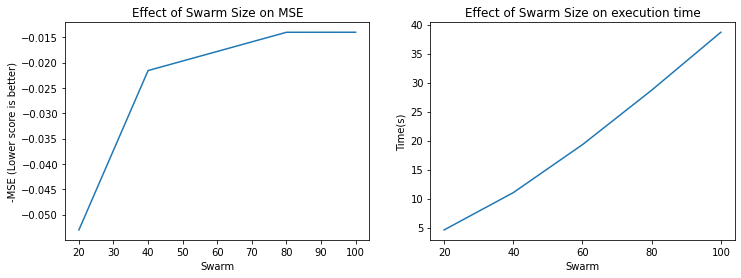

In [48]:
plt.figure(figsize=(12,4))
plt.subplot(121)
rr=np.arange(20, 120, 20)
plt.plot(rr,scores)
plt.title("Effect of Swarm Size on MSE")
plt.xlabel('Swarm')
plt.ylabel('-MSE (Lower score is better)')
plt.subplot(122)
plt.plot(rr,t)
plt.title("Effect of Swarm Size on execution time")
plt.xlabel('Swarm')
plt.ylabel('Time(s)')
plt.xticks(rr)
plt.show
print("best Score: {0}\nWorst Score: {1}".format(best[0],worst[0]))

Checking the effect of increasing velocity retention

In [49]:
scores,vs,t,best,worst=testPSO(NNConfig,swarmSize,0,1,-0.2,b,0,g,0,d,0,j,0.0,maxD,0.0,maxGS,0,epoch,0,5)

Increment: 0
Increment: 1
Increment: 2
Increment: 3
Increment: 4
time to execute all 764.1724669933319)(s)


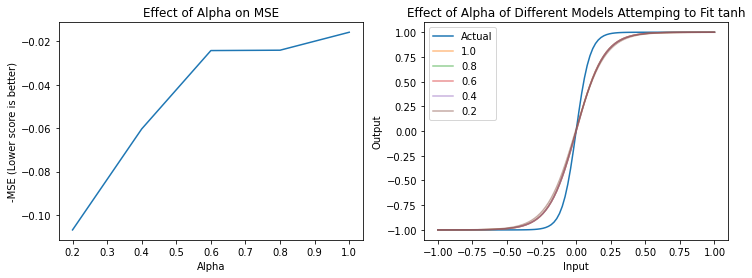

best Score: -0.01401899565847858
Worst Score: -0.017222292581461046


In [56]:
plt.figure(figsize=(12,4))
plt.subplot(121)
v=np.arange(1, 0, -0.2)
plt.plot(v,scores)
plt.title("Effect of Alpha on MSE")
plt.xlabel('Alpha')
plt.ylabel('-MSE (Lower score is better)')
plt.subplot(122)
c=NN(NNConfig)
plt.plot(x,y,label='Actual')
for i in range(len(vs)):
    c.applyVector(vs[i])
    plt.plot(x,c.feedForward(x), alpha=0.5,label=np.round(v[i],2))
plt.legend()
plt.title("Effect of Alpha of Different Models Attemping to Fit tanh")
plt.ylabel('Output')
plt.xlabel('Input')
plt.show()
print("best Score: {0}\nWorst Score: {1}".format(best[0],worst[0]))

Checking the effect of increasing global velocity retention

In [87]:
scores,vs,t,best,worst=testPSO(NNConfig,swarmSize,0,a,0.0,b,-0.20,g,-0.20,d,0.4,j,0.0,maxD,0.0,maxGS,0,epoch,0,5)

Increment: 0
Increment: 1
Increment: 2
Increment: 3
Increment: 4
time to execute all -584.1570959091187


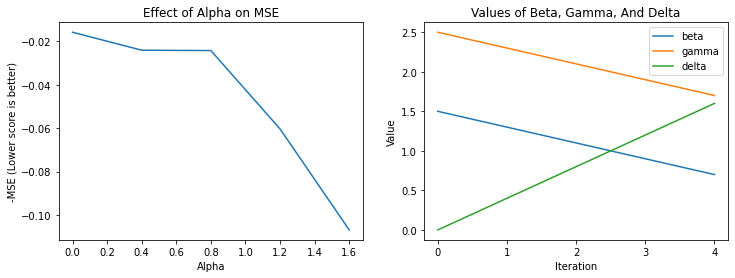

best Score: -0.01401899565847858
Worst Score: -0.017222292581461046


In [52]:
plt.figure(figsize=(12,4))
plt.subplot(121)
v=np.arange(0, 2, 0.4)
plt.plot(v,scores)
plt.title("Effect of Alpha on MSE")
plt.xlabel('Alpha')
plt.ylabel('-MSE (Lower score is better)')
plt.subplot(122)
plt.plot(np.arange(1.5, 0.5, -0.2),label='beta')
plt.plot(np.arange(2.5, 1.5, -0.2),label='gamma')
plt.plot(np.arange(0, 2, 0.4),label='delta')
plt.legend()
plt.xticks([0,1,2,3,4])
plt.title("Values of Beta, Gamma, And Delta")
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()
print("best Score: {0}\nWorst Score: {1}".format(best[0],worst[0]))

Checking the effect of increasing neural network depth

In [57]:
scores,vectors,times=[[None]*10 for i in range(3)]
t=time.time()
best,worst=[[None]*2 for i in range(2)]
best[0]=-1000
worst[0]=0
for i in range(10):
    print("Increment: {0}".format(i))
    scores[i],vector,times[i]=averagePSO([1,1+i,1],swarmSize,a,b,g,d,j,maxD,maxGS,epoch,10)
    vectors[i]=vector[1]
    if best[0]<vector[0]:
        best =vector
    if worst[0]>vector[0]:
        worst=vector
print("time to execute all {0}".format(time.time()-t))

Increment: 0
Increment: 1
Increment: 2
Increment: 3
Increment: 4
Increment: 5
Increment: 6
Increment: 7
Increment: 8
Increment: 9
time to execute all 1489.5910158157349


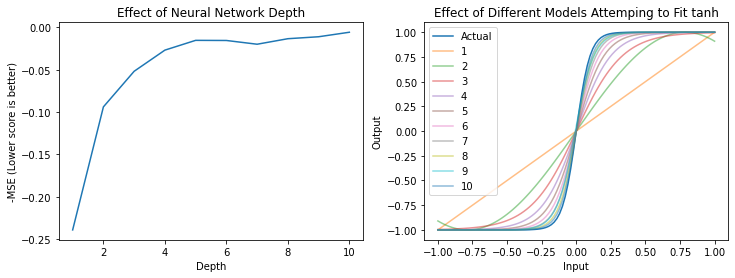

Best Score: -0.0004003410979343065
Worst Score: -0.23916918910891083


In [59]:
plt.figure(figsize=(12,4))
plt.subplot(121)
v=np.arange(1, 11, 1)
plt.plot(v,scores)
plt.title("Effect of Neural Network Depth")
plt.xlabel('Depth')
plt.ylabel('-MSE (Lower score is better)')
plt.subplot(122)
plt.plot(x,y,label='Actual')
for i in range(10):
    c=NN([1,1+i,1])
    c.applyVector(vectors[i])
    plt.plot(x,c.feedForward(x),alpha=0.5,label=i+1)
plt.legend()
plt.title("Effect of Different Models Attemping to Fit tanh")
plt.ylabel('Output')
plt.xlabel('Input')
plt.show()
print("Best Score: {0}\nWorst Score: {1}".format(best[0],worst[0]))

In [85]:
def compare(NNConfig,labelv,best,f,x,y,Graphx=True):
    if Graphx:
        c=NN(NNConfig)
        c.applyVector(best[1])
        plt.plot(x,y,label='Actual')
        plt.plot(x,c.feedForward(x),label=labelv)
        plt.legend()
        plt.title("Neural Network fitting {0}".format(f))
        plt.ylabel('Output')
        plt.xlabel('Input')
        plt.show()
    else:
        c=NN(NNConfig)
        c.applyVector(best[1])
        plt.plot(y,label='Actual')
        plt.plot(c.feedForward(x),label=labelv)
        plt.legend()
        plt.title("Neural Network fitting {0}".format(f))
        plt.ylabel('Output')
        plt.xlabel('Output')
        plt.show()

Creating Seperate Neural Nets for Different Functions
**Note Use The Function Below If You Want To Test **
im using averaged results over 10 models and selecting the best. computing 1 model for testing is suggested since it can take a lot of time doing it otherwise.

In [ ]:
#Comment previous calc and insert this instead
# averageScore,best,avgtime=PSO(NNConfig,swarmSize,a,b,g,d,j,maxD,maxGS,epoch) 
# best=[averageScore,best]

Cubic Function Model

In [184]:
f=0
swarmSize=50
a,b,g,d,j=[1,1.5,2.5,0,1]
maxD=0.3
maxGS=4
NNConfig=[1,30,1]
epoch=3000
x,y=loadFile(files[f],1)
print ("loading File: {0}".format(files[f]))
averageScore,best,avgtime=averagePSO(NNConfig,swarmSize,a,b,g,d,j,maxD,maxGS,epoch,10) #Comment this as recommended
#insert the given section here the code doesnt need any adjustments even for the ones below
# averageScore,best,avgtime=PSO(NNConfig,swarmSize,a,b,g,d,j,maxD,maxGS,epoch) 
# best=[averageScore,best]

loading File: Data/1in_cubic.txt


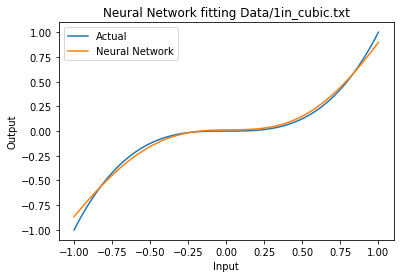

Avg Score: -0.0045683307692715135
Avg Time: 483.20959558486936
Best Score: -0.001167257206012709


In [185]:
compare(NNConfig,'Neural Network',best,files[f],x,y)
print("Avg Score: {0}\nAvg Time: {1}\nBest Score: {2}".format(averageScore,avgtime,best[0]))

Linear Function Model

In [104]:
f=1
swarmSize=50
a,b,g,d,j=[0.9,1.5,2.5,0,1.0]
maxD=0.30
maxGS=4
NNConfig=[1,1]
epoch=10
x,y=loadFile(files[f],1)
print ("loading File: {0}".format(files[f]))
averageScore,best,avgtime=averagePSO(NNConfig,swarmSize,a,b,g,d,j,maxD,maxGS,epoch,10)# "10" is average over 10 iterations

loading File: Data/1in_linear.txt


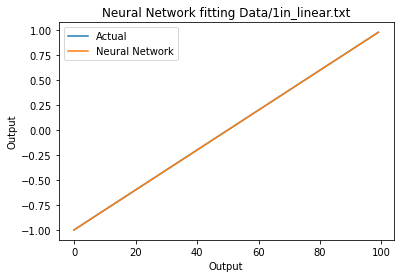

Avg Score: 0.0
Avg Time: 0.7028195142745972
Best Score: -0.0


In [105]:
compare(NNConfig,'Neural Network',best,files[f],x,y)
print("Avg Score: {0}\nAvg Time: {1}\nBest Score: {2}".format(averageScore,avgtime,best[0]))

Sine Function Model

In [90]:
f=2
swarmSize=50
a,b,g,d,j=[0.9,1.5,2.5,0,1.0]
maxD=0.30
maxGS=4
NNConfig=[1,4,1]
epoch=50
x,y=loadFile(files[f],1)
print ("loading File: {0}".format(files[f]))
averageScore,best,avgtime=averagePSO(NNConfig,swarmSize,a,b,g,d,j,maxD,maxGS,epoch,10)# "10" is average over 10 iterations

loading File: Data/1in_sine.txt


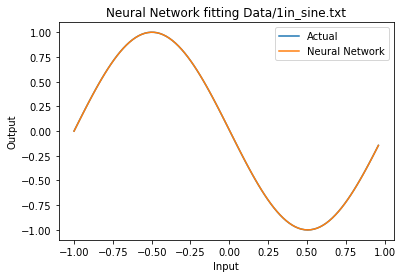

Avg Score: -8.140851382758938e-05
Avg Time: 16.11097550392151
Best Score: -2.7548512337773273e-07


In [91]:
compare(NNConfig,'Neural Network',best,files[f],x,y)
print("Avg Score: {0}\nAvg Time: {1}\nBest Score: {2}".format(averageScore,avgtime,best[0]))

Tanh Function Model

In [122]:
f=3
swarmSize=50
a,b,g,d,j=[0.9,1.5,2.5,0,1.0]
maxD=0.30
maxGS=4
NNConfig=[1,14,1]
epoch=200
x,y=loadFile(files[f],1)
print ("loading File: {0}".format(files[f]))
averageScore,best,avgtime=averagePSO(NNConfig,swarmSize,a,b,g,d,j,maxD,maxGS,epoch,10)

loading File: Data/1in_tanh.txt


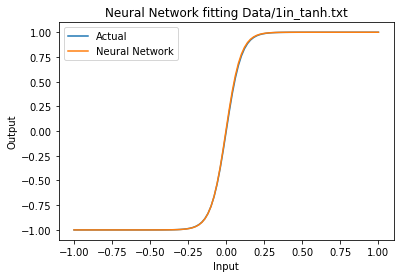

Avg Score: -0.0014819983197342605
Avg Time: 33.29649183750153
Best Score: -3.9087916009526525e-05


In [123]:
compare(NNConfig,'Neural Network',best,files[f],x,y)
print("Avg Score: {0}\nAvg Time: {1}\nBest Score: {2}".format(averageScore,avgtime,best[0]))

Complex Function Model

In [197]:
f=4
swarmSize=100
a,b,g,d,j=[0.9,1.5,2.5,0,1.0]
maxD=0.30
maxGS=4
NNConfig=[2,30,10,10,1]
epoch=3000
x,y=loadFile(files[f],1)
print ("loading File: {0}".format(files[f]))
averageScore,best,avgtime=averagePSO(NNConfig,swarmSize,a,b,g,d,j,maxD,maxGS,epoch,10) 

loading File: Data/2in_complex.txt


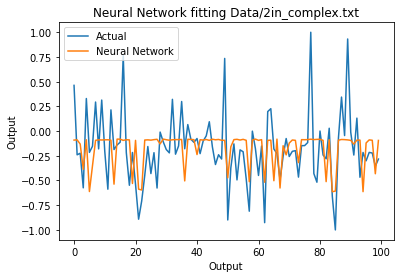

Avg Score: -0.09670421104107568
Avg Time: 5317.739447593689
Best Score: -0.09670421104107568


In [198]:
compare(NNConfig,'Neural Network',best,files[f],x,y,False)
print("Avg Score: {0}\nAvg Time: {1}\nBest Score: {2}".format(averageScore,avgtime,best[0]))

XOR Function Model

In [98]:
f=5
swarmSize=50
a,b,g,d,j=[0.9,1.5,2.0,0.5,1]
maxD=0.30
maxGS=4
NNConfig=[2,2,1]
epoch=20
x,y=loadFile(files[f],1)
print ("loading File: {0}".format(files[f]))
averageScore,best,avgtime=averagePSO(NNConfig,swarmSize,a,b,g,d,j,maxD,maxGS,epoch,10) 

loading File: Data/2in_xor.txt


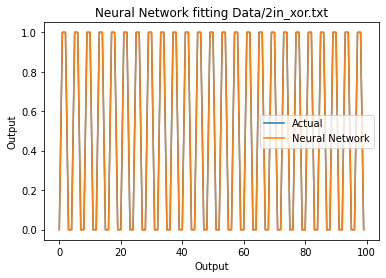

Avg Score: -0.0008800942956743166
Avg Time: 2.784889268875122
Best Score: -2.902072044775604e-06


In [99]:
compare(NNConfig,'Neural Network',best,files[f],x,y,False)
print("Avg Score: {0}\nAvg Time: {1}\nBest Score: {2}".format(averageScore,avgtime,best[0]))